In [1]:
# load the prepared dataset
from numpy import load
# load the face dataset
data = load('/content/drive/My Drive/GAN/img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

Loaded:  (50000, 80, 80, 3)


In [2]:
#Loading the libraries
from math import sqrt
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from skimage.transform import resize
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import LeakyReLU
from keras.layers import Layer
from keras.layers import Add
from keras.constraints import max_norm
from keras.initializers import RandomNormal
from keras import backend
from matplotlib import pyplot

Using TensorFlow backend.


Loaded:  (50000, 80, 80, 3)


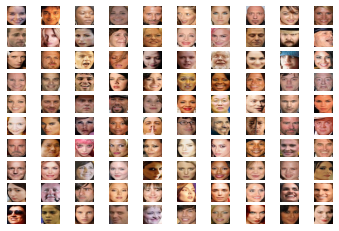

In [3]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot

# plot a list of loaded faces
def plot_faces(faces, n):
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(faces[i].astype('uint8'))
	pyplot.show()

# load the face dataset
data = load('/content/drive/My Drive/GAN/img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)
plot_faces(faces, 10)

In [0]:
# weighted sum output
class WeightedSum(Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = backend.variable(alpha, name='ws_alpha')

	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

In [0]:
# mini-batch standard deviation layer
class MinibatchStdev(Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(MinibatchStdev, self).__init__(**kwargs)

	# perform the operation
	def call(self, inputs):
		# calculate the mean value for each pixel across channels
		mean = backend.mean(inputs, axis=0, keepdims=True)
		# calculate the squared differences between pixel values and mean
		squ_diffs = backend.square(inputs - mean)
		# calculate the average of the squared differences (variance)
		mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
		# add a small value to avoid a blow-up when we calculate stdev
		mean_sq_diff += 1e-8
		# square root of the variance (stdev)
		stdev = backend.sqrt(mean_sq_diff)
		# calculate the mean standard deviation across each pixel coord
		mean_pix = backend.mean(stdev, keepdims=True)
		# scale this up to be the size of one input feature map for each sample
		shape = backend.shape(inputs)
		output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
		# concatenate with the output
		combined = backend.concatenate([inputs, output], axis=-1)
		return combined

	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		# create a copy of the input shape as a list
		input_shape = list(input_shape)
		# add one to the channel dimension (assume channels-last)
		input_shape[-1] += 1
		# convert list to a tuple
		return tuple(input_shape)

In [0]:
# pixel-wise feature vector normalization layer
class PixelNormalization(Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(PixelNormalization, self).__init__(**kwargs)

	# perform the operation
	def call(self, inputs):
		# calculate square pixel values
		values = inputs**2.0
		# calculate the mean pixel values
		mean_values = backend.mean(values, axis=-1, keepdims=True)
		# ensure the mean is not zero
		mean_values += 1.0e-8
		# calculate the sqrt of the mean squared value (L2 norm)
		l2 = backend.sqrt(mean_values)
		# normalize values by the l2 norm
		normalized = inputs / l2
		return normalized

	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		return input_shape

In [0]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [0]:
#add discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2].value*2, in_shape[-2].value*2, in_shape[-1].value)
	in_image = Input(shape=input_shape)
	# define new input processing layer
	d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# define new block
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = Model(in_image, d)
	# compile model
	model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = Model(in_image, d)
	# compile model
	model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]

In [0]:
# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = MinibatchStdev()(d)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1)(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

In [0]:
#add generator block
def add_generator_block(old_model):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	# get the end of the last block
	block_end = old_model.layers[-2].output
	# upsample, and define new block
	upsampling = UpSampling2D()(block_end)
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
	g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# add new output layer
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	# define model
	model1 = Model(old_model.input, out_image)
	# get the output layer from old model
	out_old = old_model.layers[-1]
	# connect the upsampling to the old output layer
	out_image2 = out_old(upsampling)
	# define new output image as the weighted sum of the old and new models
	merged = WeightedSum()([out_image2, out_image])
	# define model
	model2 = Model(old_model.input, merged)
	return [model1, model2]

In [0]:
# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	model_list = list()
	# base model latent input
	in_latent = Input(shape=(latent_dim,))
	# linear scale up to activation maps
	g  = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
	g = Reshape((in_dim, in_dim, 128))(g)
	# conv 4x4, input block
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 3x3
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 1x1, output block
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	# define model
	model = Model(in_latent, out_image)
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_generator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

In [0]:
# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
	model_list = list()
	# create composite models
	for i in range(len(discriminators)):
		g_models, d_models = generators[i], discriminators[i]
		# straight-through model
		d_models[0].trainable = False
		model1 = Sequential()
		model1.add(g_models[0])
		model1.add(d_models[0])
		model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# fade-in model
		d_models[1].trainable = False
		model2 = Sequential()
		model2.add(g_models[1])
		model2.add(d_models[1])
		model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# store
		model_list.append([model1, model2])
	return model_list

In [0]:
# load dataset
def load_real_samples(filename):
	# load dataset
	data = load(filename)
	# extract numpy array
	X = data['arr_0']
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = -ones((n_samples, 1))
	return X, y

In [0]:
# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
	# calculate current alpha (linear from 0 to 1)
	alpha = step / float(n_steps - 1)
	# update the alpha for each model
	for model in models:
		for layer in model.layers:
			if isinstance(layer, WeightedSum):
				backend.set_value(layer.alpha, alpha)

In [0]:
# train a generator and discriminator
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# update alpha for all WeightedSum layers when fading in new blocks
		if fadein:
			update_fadein([g_model, d_model, gan_model], i, n_steps)
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

In [0]:
# scale images to preferred size
def scale_dataset(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(status, g_model, latent_dim, n_samples=25):
	# devise name
	gen_shape = g_model.output_shape
	name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
	# generate images
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# normalize pixel values to the range [0,1]
	X = (X - X.min()) / (X.max() - X.min())
	# plot real images
	square = int(sqrt(n_samples))
	for i in range(n_samples):
		pyplot.subplot(square, square, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = '/content/drive/My Drive/Progressive_Growing_GAN/plot_%s.png' % (name)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/drive/My Drive/Progressive_Growing_GAN/model_%s.h5' % (name)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [0]:
# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
	# fit the baseline model
	g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
	# scale dataset to appropriate size
	gen_shape = g_normal.output_shape
	scaled_data = scale_dataset(dataset, gen_shape[1:])
	print('Scaled Data', scaled_data.shape)
	# train normal or straight-through models
	train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
	summarize_performance('tuned', g_normal, latent_dim)
	# process each level of growth
	for i in range(1, len(g_models)):
		# retrieve models for this level of growth
		[g_normal, g_fadein] = g_models[i]
		[d_normal, d_fadein] = d_models[i]
		[gan_normal, gan_fadein] = gan_models[i]
		# scale dataset to appropriate size
		gen_shape = g_normal.output_shape
		scaled_data = scale_dataset(dataset, gen_shape[1:])
		print('Scaled Data', scaled_data.shape)
		# train fade-in models for next level of growth
		train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
		summarize_performance('faded', g_fadein, latent_dim)
		# train normal or straight-through models
		train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
		summarize_performance('tuned', g_normal, latent_dim)

In [0]:
# number of growth phases, e.g. 6 == [4, 8, 16, 32, 64, 128]
n_blocks = 6
# size of the latent space
latent_dim = 100
# define models
d_models = define_discriminator(n_blocks)
# define models
g_models = define_generator(latent_dim, n_blocks)
# define composite models
gan_models = define_composite(d_models, g_models)
# load image data
dataset = load_real_samples('/content/drive/My Drive/GAN/img_align_celeba.npz')
print('Loaded', dataset.shape)
# train model
n_batch = [16, 16, 16, 8, 4, 4]
# 10 epochs == 500K images per training phase
n_epochs = [5, 8, 8, 10, 10, 10]
train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch)








Loaded (50000, 80, 80, 3)
Scaled Data (50000, 4, 4, 3)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1=0.004, d2=0.021 g=0.006
>2, d1=-0.011, d2=0.087 g=0.007
>3, d1=-0.011, d2=0.026 g=0.000
>4, d1=-0.010, d2=0.027 g=-0.003
>5, d1=-0.008, d2=0.010 g=-0.003
>6, d1=-0.013, d2=0.047 g=-0.003
>7, d1=-0.008, d2=0.026 g=-0.001
>8, d1=-0.004, d2=0.009 g=-0.003


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>10629, d1=0.001, d2=0.002 g=0.001
>10630, d1=-0.000, d2=0.003 g=0.000
>10631, d1=-0.001, d2=0.004 g=0.000
>10632, d1=0.001, d2=0.003 g=0.001
>10633, d1=0.000, d2=0.003 g=0.000
>10634, d1=-0.001, d2=0.003 g=0.002
>10635, d1=0.001, d2=0.003 g=0.001
>10636, d1=0.001, d2=0.002 g=0.000
>10637, d1=0.000, d2=0.003 g=0.000
>10638, d1=-0.001, d2=0.002 g=0.000
>10639, d1=-0.001, d2=0.007 g=-0.001
>10640, d1=-0.001, d2=0.006 g=0.000
>10641, d1=-0.000, d2=0.004 g=-0.000
>10642, d1=-0.001, d2=0.004 g=0.000
>10643, d1=-0.002, d2=0.006 g=-0.000
>10644, d1=-0.000, d2=0.004 g=0.000
>10645, d1=-0.000, d2=0.003 g=-0.000
>10646, d1=-0.001, d2=0.004 g=-0.001
>10647, d1=-0.001, d2=0.004 g=-0.001
>10648, d1=-0.003, d2=0.000 g=0.008
>10649, d1=0.010, d2=0.005 g=0.005
>10650, d1=0.004, d2=0.007 g=0.002
>10651, d1=0.002, d2=0.004 g=0.001
>10652, d1=-0.000, d2=0.004 g=0.001
>10653, d1=0.002, d2=0.003 g=0.001
>10654, d1=0.001, d2=0.002 g=0.001
>10655, d1=0.000, 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1=0.001, d2=0.002 g=0.000
>2, d1=0.001, d2=0.002 g=0.001
>3, d1=0.001, d2=0.003 g=0.001
>4, d1=0.000, d2=0.004 g=0.001
>5, d1=0.001, d2=0.003 g=0.000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>20003, d1=-2.537, d2=0.711 g=-2.823
>20004, d1=-2.028, d2=1.955 g=1.324
>20005, d1=-3.198, d2=-3.756 g=4.193
>20006, d1=-5.631, d2=3.100 g=-0.053
>20007, d1=-2.653, d2=0.793 g=-1.492
>20008, d1=-3.253, d2=4.013 g=0.914
>20009, d1=-2.479, d2=3.631 g=-3.032
>20010, d1=-3.813, d2=4.465 g=-2.917
>20011, d1=-1.731, d2=3.607 g=-2.508
>20012, d1=-4.825, d2=5.795 g=-1.507
>20013, d1=-4.777, d2=3.938 g=-1.379
>20014, d1=-2.026, d2=2.132 g=-2.566
>20015, d1=-1.111, d2=3.235 g=-2.235
>20016, d1=-2.218, d2=3.033 g=-2.430
>20017, d1=-1.940, d2=2.592 g=-0.751
>20018, d1=-1.978, d2=2.725 g=-2.769
>20019, d1=-1.742, d2=4.471 g=-1.289
>20020, d1=-1.290, d2=2.748 g=-2.524
>20021, d1=-2.390, d2=3.444 g=-1.026
>20022, d1=-1.507, d2=2.780 g=-1.491
>20023, d1=-2.031, d2=-0.064 g=-1.027
>20024, d1=1.753, d2=-0.343 g=0.463
>20025, d1=-1.663, d2=1.743 g=-0.340
>20026, d1=0.043, d2=1.112 g=-1.237
>20027, d1=0.061, d2=2.095 g=0.150
>20028, d1=-1.904, d2=1.850 g

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1=-1.316, d2=2.748 g=1.457
>2, d1=-3.909, d2=1.208 g=-0.665
>3, d1=6.718, d2=6.311 g=-0.469
>4, d1=-4.220, d2=1.113 g=0.316
>5, d1=-3.415, d2=6.617 g=-1.459


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>6010, d1=-7.396, d2=10.520 g=-1.930
>6011, d1=-10.230, d2=6.906 g=10.951
>6012, d1=-6.637, d2=7.942 g=0.611
>6013, d1=-5.250, d2=4.075 g=-3.165
>6014, d1=-2.181, d2=7.118 g=-2.409
>6015, d1=-3.585, d2=7.523 g=-4.453
>6016, d1=-5.613, d2=8.455 g=-5.365
>6017, d1=-3.253, d2=6.885 g=-3.873
>6018, d1=-2.020, d2=9.495 g=-0.818
>6019, d1=-5.794, d2=7.829 g=-4.143
>6020, d1=-4.439, d2=5.051 g=-1.001
>6021, d1=-2.940, d2=5.309 g=-4.453
>6022, d1=-5.917, d2=9.463 g=-4.185
>6023, d1=-4.235, d2=6.996 g=-2.921
>6024, d1=-8.359, d2=5.054 g=-4.353
>6025, d1=-10.261, d2=5.389 g=-4.634
>6026, d1=-7.432, d2=8.120 g=-2.995
>6027, d1=-8.982, d2=10.454 g=-3.620
>6028, d1=-6.272, d2=7.700 g=-3.982
>6029, d1=-4.987, d2=6.291 g=-4.690
>6030, d1=-8.618, d2=2.984 g=-3.257
>6031, d1=-8.348, d2=4.088 g=-1.435
>6032, d1=-6.743, d2=17.200 g=-8.100
>6033, d1=-9.728, d2=12.326 g=-6.803
>6034, d1=-6.747, d2=7.575 g=-4.227
>6035, d1=-5.519, d2=8.468 g=-4.067
>6036, d